# Preparation
We need to load reference model for code examples in this section. First, we will train the model in this runtime.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim

In [2]:
# For reproducability
torch.manual_seed(0)

In [3]:
class Net(nn.Module):
  def __init__(self, in_dim, feature_dim, out_dim):
    super(Net, self).__init__()
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_dim, feature_dim),
        nn.ReLU(),
        nn.Linear(feature_dim, feature_dim),
        nn.ReLU(),
        nn.Linear(feature_dim, out_dim),
        nn.ReLU()
    )

  def forward(self, inputs):
    return self.classifier(inputs)

In [4]:
trainset = MNIST('.', train=True, download=True, 
                      transform=ToTensor())
testset = MNIST('.', train=False, download=True, 
                      transform=ToTensor())
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
IN_DIM, FEATURE_DIM, OUT_DIM = 784, 256, 10
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
num_epochs = 40
classifier = Net(IN_DIM, FEATURE_DIM, OUT_DIM)
optimizer = optim.SGD(classifier.parameters(), lr=lr)
classifier

Net(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [6]:
for epochs in range(num_epochs):
  running_loss = 0.0
  for inputs, labels in trainloader:
    optimizer.zero_grad()
    outputs = classifier(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  print(running_loss/len(trainloader))


2.304971021121499
2.302525174643185
2.299957237772342
2.297387815741842
2.294872467197589
2.292390913088947
2.2899169403352717
2.2874326375501752
2.2849312514892772
2.2823666710335053
2.279773563972668
2.277095660471967
2.27435744266266
2.2715469652147435
2.268646004865927
2.2656551421578253
2.2625733082736734
2.259384568820376
2.256069576816518
2.2526530426448343
2.2490698691370135
2.2453533286478984
2.241465627003326
2.237424060225741
2.2331880450502894
2.228737404859905
2.2240895998757533
2.219208516800073
2.214078137106987
2.2086960834734986
2.2030509750980305
2.1971164784197614
2.1908428282625896
2.184254756868521
2.1773439655934315
2.170090768128824
2.162415165382662
2.154347401692161
2.1458973089006665
2.136968573781727


In [7]:
model = classifier
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", 
          model.state_dict()[param_tensor].size())
    
# out:
# Model's state_dict:
# classifier.1.weight 	torch.Size([256, 784])
# classifier.1.bias 	  torch.Size([256])
# classifier.3.weight 	torch.Size([256, 256])
# classifier.3.bias 	  torch.Size([256])
# classifier.5.weight 	torch.Size([10, 256])
# classifier.5.bias 	  torch.Size([10])

Model's state_dict:
classifier.1.weight 	 torch.Size([256, 784])
classifier.1.bias 	 torch.Size([256])
classifier.3.weight 	 torch.Size([256, 256])
classifier.3.bias 	 torch.Size([256])
classifier.5.weight 	 torch.Size([10, 256])
classifier.5.bias 	 torch.Size([10])


In [8]:
# Save state to file as checkpoint
torch.save(model.state_dict(), 'mnist.pt')

# How Pesky Are Spurious Local Minima in Deep Networks?

In [9]:
# Load checkpoint from SGD training
IN_DIM, FEATURE_DIM, OUT_DIM = 784, 256, 10
model = Net(IN_DIM, FEATURE_DIM, OUT_DIM)

model.load_state_dict(torch.load('mnist.pt'))

<All keys matched successfully>

In [10]:
import copy 

# Access parameters with state_dict
opt_state_dict = copy.deepcopy(model.state_dict())

for param_tensor in opt_state_dict:
    print(param_tensor, "\t", 
          opt_state_dict[param_tensor].size())

# outputs:
# classifier.1.weight 	torch.Size([256, 784])
# classifier.1.bias 	  torch.Size([256])
# classifier.3.weight 	torch.Size([256, 256])
# classifier.3.bias 	  torch.Size([256])
# classifier.5.weight 	torch.Size([10, 256])
# classifier.5.bias 	  torch.Size([10])

classifier.1.weight 	 torch.Size([256, 784])
classifier.1.bias 	 torch.Size([256])
classifier.3.weight 	 torch.Size([256, 256])
classifier.3.bias 	 torch.Size([256])
classifier.5.weight 	 torch.Size([10, 256])
classifier.5.bias 	 torch.Size([10])


In [11]:
# Create randomly initialized network
model_rand = Net(IN_DIM, FEATURE_DIM, OUT_DIM)
rand_state_dict = copy.deepcopy(model_rand.state_dict())

In [12]:
# Create a new state_dict for interpolated parameters
test_model = Net(IN_DIM, FEATURE_DIM, OUT_DIM)
test_state_dict = copy.deepcopy(test_model.state_dict())

alpha = 0.2
beta = 1.0 - alpha
for p in opt_state_dict:
    test_state_dict[p] = (opt_state_dict[p] * beta + 
                          rand_state_dict[p] * alpha)

In [13]:
def inference(testloader, model, loss_fn):
  running_loss = 0.0
  with torch.no_grad():
    for inputs, labels in testloader:
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      running_loss += loss
  running_loss /= len(testloader)
  return running_loss

In [14]:
opt_state_dict['classifier.1.weight'][0][0]

tensor(-0.0003)

In [ ]:
results = []
for alpha in torch.arange(-2, 2, 0.01):
  beta = 1.0 - alpha
  
  # Compute interpolated parameters
  for p in opt_state_dict:
    test_state_dict[p] = (opt_state_dict[p] * beta + 
                          rand_state_dict[p] * alpha)
  
  # Load interpolated parameters into test model
  model.load_state_dict(test_state_dict)
  
  # Compute Loss given interpolated parameters
  loss = inference(trainloader, model, loss_fn)
  results.append(loss.item())
  print(loss.item())


Text(0.5, 0, 'Alpha')

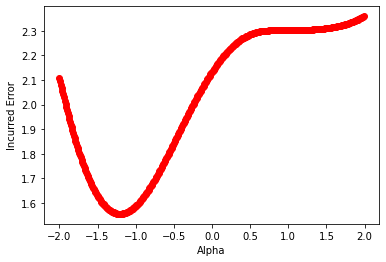

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(-2, 2, 0.01), results, 'ro')
plt.ylabel('Incurred Error')
plt.xlabel('Alpha')

# Momentum-Based Optimization

In [29]:
import torch
torch.randint(-10, 10, (1,1))

tensor([[8]])

In [30]:
#
rand_walk = [torch.randint(-10, 10, (1,1)) for x in range(100)]

In [31]:
# 
momentum = 0.1
momentum_rand_walk = \
      [torch.randint(-10, 10, (1,1)) for x in range(100)]

for i in range(1, len(rand_walk) - 1):
  prev = momentum_rand_walk[i-1]
  rand_choice = torch.randint(-10, 10, (1,1)).item()
  new_step = momentum * prev + (1 - momentum) * rand_choice
  momentum_rand_walk[i] = new_step

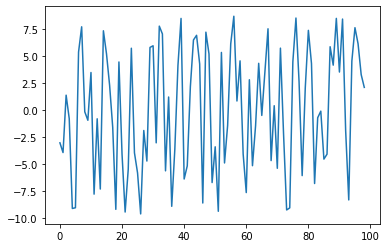

In [21]:
import matplotlib.pyplot as plt

plt.plot(momentum_rand_walk[:-1])

In [22]:
from torch import optim, nn
# example model
model = nn.Conv2d(1,32,3)

In [23]:
# 
optimizer = optim.SGD(model.parameters(),
                      lr = 0.01,
                      momentum = 0.9)

optimizer.step()

In [24]:
optimizer = optim.SGD(model.parameters(),
                      lr = 0.01,
                      momentum = 0.9,
                      nesterov = True)


# AdaGrad—Accumulating Historical Gradients

In [25]:
optimizer = optim.Adagrad(model.parameters(),
                          lr = 0.01,
                          weight_decay = 0,
                          initial_accumulator_value = 0)

# RMSProp—Exponentially Weighted Moving Average of Gradients

In [26]:
optimizer = optim.RMSprop(model.parameters(),
                          lr = 0.01,
                          alpha = 0.99,
                          eps = 1e-8,
                          weight_decay = 0,
                          momentum = 0)

# Adam—Combining Momentum and RMSProp

In [27]:
optimizer = optim.Adam(model.parameters(),
                       lr = 0.001,
                       betas = (0.9, 0.999),
                       eps = 1e-08,
                       weight_decay = 0,
                       amsgrad = False)